In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import numpy as np

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, LSTM

from tsextract.feature_extraction.extract import build_features 

import matplotlib as plt

In [2]:
df_init = pd.read_csv('4362249.csv')
df_init.head()

,DateTime,Vehicles
0,01 00:00:00,559
1,01 01:00:00,585
2,01 02:00:00,425
3,01 03:00:00,284
4,01 04:00:00,389


In [3]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
def reshape_X(X, n_features):
    X.reshape((X.shape[0], X.shape[1], n_features))
    return X

In [5]:
TRAIN_RATIO = 0.8

time_serie = df_init['Vehicles']

ts_scaler = StandardScaler()

time_serie_train = time_serie[:int(time_serie.shape[0] * TRAIN_RATIO)]
time_serie_test = time_serie[int(time_serie.shape[0] * TRAIN_RATIO):]

time_serie_train_scaled = ts_scaler.fit_transform(time_serie_train.values.reshape(-1, 1))
time_serie_test_scaled = ts_scaler.fit_transform(time_serie_test.values.reshape(-1, 1))

In [6]:
n_steps = 24
n_features = 1

X_train_scaled, y_train_scaled = split_sequence(time_serie_train_scaled, n_steps)
X_train_scaled_reshaped =  reshape_X(X_train_scaled, n_features)

X_test_scaled, y_test_scaled = split_sequence(time_serie_test_scaled, n_steps)

0.796226468716527
129.97396091863288
99.32338434855143


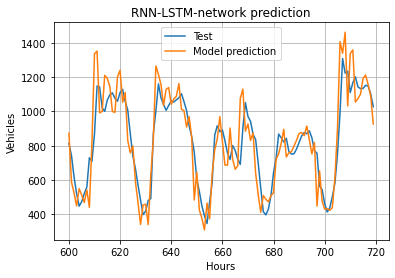

In [7]:
model = Sequential()

neuron_in_layers = 100

model.add(LSTM(50, return_sequences = False, input_shape = (n_steps, n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train_scaled_reshaped, y_train_scaled, epochs = 100, batch_size = 50, verbose = 0)

y_predict = ts_scaler.inverse_transform(model.predict(X_test_scaled))
y_predict_df = pd.DataFrame(y_predict, index = time_serie_test[n_steps:].index)
y_test_df = pd.DataFrame(time_serie_test[n_steps:], index = y_predict_df.index)

ax = y_predict_df.plot()
y_test_df.plot(ax = ax)

ax.legend(['Test', 'Model prediction'])
ax.set_xlabel('Hours')
ax.set_ylabel('Vehicles')
ax.set_title('RNN-LSTM-network prediction')
ax.grid('on')

print(r2_score(y_test_df, y_predict_df))
print(mean_squared_error(y_test_df, y_predict_df, squared=False))
print(mean_absolute_error(y_test_df, y_predict_df))